# Model V0 
初步套用 `BERT-Chinese` 進行訓練

In [28]:
import os 
os.chdir("/home/clll/AiIdea_text/")
import tensorflow as tf
from tensorflow.data import Dataset
import pandas as pd
from transformers import AutoTokenizer, TFAutoModel
import random
import matplotlib.pyplot as plt

In [3]:
train_text = pd.read_csv("./data/train_text.csv")
train_label = pd.read_csv("./data/train_label.csv")

## 進行斷詞

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese")

因為尚未進行裁切，所以會顯示警告。

In [5]:
train_text['text_encoded'] = train_text.text.apply(lambda x: tokenizer.encode(list(x), add_special_tokens=False))

Token indices sequence length is longer than the specified maximum sequence length for this model (4212 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2653 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1690 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1230 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (768 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for

In [6]:
train_text

,article_id,text,text_encoded
0,0,醫師：啊回去還好嗎？民眾：欸，還是虛虛的，但。醫師：欸，真的。民眾：好險好險。坦白講我剛回去...,"[7015, 2374, 8038, 1557, 1726, 1343, 6917, 196..."
1,1,醫師：阿阿嬤她好像說有，前天又有在發燒喔。家屬：對阿都，有時候都會一天她會燒，誒，可是她這樣...,"[7015, 2374, 8038, 7350, 7350, 2085, 1961, 196..."
2,2,民眾：也有點不舒服，可是就是腰這邊有也一點點痛，我脫起來我想……。醫師：來我看一下。民眾：看...,"[3696, 4707, 8038, 738, 3300, 7953, 679, 5653,..."
3,3,醫師：謝謝你這樣幫忙他們這樣，那最近還好嗎？民眾：就是因為不太好所以才要再回診，因為我為甚麼...,"[7015, 2374, 8038, 6342, 6342, 872, 6857, 3564..."
4,4,醫師：那個，吃藥還Ok嗎？民眾：OK。醫師：沒什麼問題？民眾：沒有。醫師：我們這次CD4是3...,"[7015, 2374, 8038, 6929, 943, 8024, 1391, 5973..."
...,...,...,...
115,115,醫師：所以今天是爲了暴露前預防嘛？民衆：嗯。醫師：你身邊有其他人在吃的嗎？民衆：沒有欸。醫師...,"[7015, 2374, 8038, 2792, 809, 791, 1921, 3221,..."
116,116,醫師：所以你這個月，你是任務型嗎？民眾：對。醫師：阿吃幾組？民眾：我印象中應該有4組。醫師：...,"[7015, 2374, 8038, 2792, 809, 872, 6857, 943, ..."
117,117,醫師：這個月還好嗎？民衆：這個月還好，上班比較無聊而已。醫師：還可以，上班沒有人有聊的啊。所...,"[7015, 2374, 8038, 6857, 943, 3299, 6917, 1962..."
118,118,醫師：那所以今天是要這個暴露前預防？民眾：對。醫師：欸……你，怎麼知道我們的？民眾：因為我是...,"[7015, 2374, 8038, 6929, 2792, 809, 791, 1921,..."


順便觀察每篇對話的character數量 (接下來可以發現 Label 極度不平均)

In [7]:
train_text.text_encoded.apply(lambda x: len(x)).describe()

count     120.000000
mean     2110.950000
std      1133.878299
min       568.000000
25%      1286.750000
50%      1763.000000
75%      2625.250000
max      7310.000000
Name: text_encoded, dtype: float64

## 整理 Label 欄位

In [8]:
train_label

,article_id,start_position,end_position,entity_text,entity_type
0,0,69,71,前天,time
1,0,75,77,前天,time
2,0,738,740,85,med_exam
3,0,741,744,102,med_exam
4,0,809,811,前年,time
...,...,...,...,...,...
2131,119,1136,1138,彰化,location
2132,119,1143,1145,彰化,location
2133,119,1173,1177,彰化醫院,location
2134,119,1216,1221,陳明明醫師,name


In [9]:
result = {}
for a_id in train_text.article_id.iloc:
    text_encoded = train_text.query("article_id=={}".format(a_id)).iloc[0].text_encoded
    label = ["other"] * len(text_encoded)
    # ground truth
    gt = train_label.query("article_id=={}".format(a_id))

    for _, a_gt in gt.iterrows():
        start_pos = a_gt.start_position
        end_pos = a_gt.end_position
        entity_type = a_gt.entity_type
        position = list(range(int(start_pos), int(end_pos)))
        for x, y in zip(position, [entity_type] * len(position)):
            label[x] = y
    result[a_id] = label

In [10]:
label_preprocessed = pd.DataFrame({"article_id":result.keys(), "label":result.values()})
label_preprocessed

,article_id,label
0,0,"[other, other, other, other, other, other, oth..."
1,1,"[other, other, other, other, other, other, oth..."
2,2,"[other, other, other, other, other, other, oth..."
3,3,"[other, other, other, other, other, other, oth..."
4,4,"[other, other, other, other, other, other, oth..."
...,...,...
115,115,"[other, other, other, other, other, time, time..."
116,116,"[other, other, other, other, other, other, tim..."
117,117,"[other, other, other, time, time, time, other,..."
118,118,"[other, other, other, other, other, other, tim..."


將label轉換成index

In [11]:
temp = list()
for i in label_preprocessed.label:
    temp += i
count = pd.DataFrame({'code':temp}).code.value_counts()
label2idx = {v:k for (k,v) in enumerate(count.keys())}
count

other             246748
time                4578
med_exam             606
name                 453
location             401
money                272
contact               98
profession            53
family                53
ID                    23
clinical_event        20
education              6
organization           3
Name: code, dtype: int64

In [12]:
label2idx

{'other': 0,
 'time': 1,
 'med_exam': 2,
 'name': 3,
 'location': 4,
 'money': 5,
 'contact': 6,
 'profession': 7,
 'family': 8,
 'ID': 9,
 'clinical_event': 10,
 'education': 11,
 'organization': 12}

In [13]:
label_preprocessed["label_encoded"] = label_preprocessed.label.apply(lambda x:[label2idx[ele] for ele in x])

In [14]:
label_preprocessed

,article_id,label,label_encoded
0,0,"[other, other, other, other, other, other, oth...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,"[other, other, other, other, other, other, oth...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ..."
2,2,"[other, other, other, other, other, other, oth...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,"[other, other, other, other, other, other, oth...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,"[other, other, other, other, other, other, oth...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
115,115,"[other, other, other, other, other, time, time...","[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
116,116,"[other, other, other, other, other, other, tim...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."
117,117,"[other, other, other, time, time, time, other,...","[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, ..."
118,118,"[other, other, other, other, other, other, tim...","[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."


把處理好的文章跟label Merge成同一個Data Frame

In [15]:
preprocessed_df = pd.merge(train_text, label_preprocessed)
preprocessed_df

,article_id,text,text_encoded,label,label_encoded
0,0,醫師：啊回去還好嗎？民眾：欸，還是虛虛的，但。醫師：欸，真的。民眾：好險好險。坦白講我剛回去...,"[7015, 2374, 8038, 1557, 1726, 1343, 6917, 196...","[other, other, other, other, other, other, oth...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,醫師：阿阿嬤她好像說有，前天又有在發燒喔。家屬：對阿都，有時候都會一天她會燒，誒，可是她這樣...,"[7015, 2374, 8038, 7350, 7350, 2085, 1961, 196...","[other, other, other, other, other, other, oth...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ..."
2,2,民眾：也有點不舒服，可是就是腰這邊有也一點點痛，我脫起來我想……。醫師：來我看一下。民眾：看...,"[3696, 4707, 8038, 738, 3300, 7953, 679, 5653,...","[other, other, other, other, other, other, oth...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,醫師：謝謝你這樣幫忙他們這樣，那最近還好嗎？民眾：就是因為不太好所以才要再回診，因為我為甚麼...,"[7015, 2374, 8038, 6342, 6342, 872, 6857, 3564...","[other, other, other, other, other, other, oth...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,醫師：那個，吃藥還Ok嗎？民眾：OK。醫師：沒什麼問題？民眾：沒有。醫師：我們這次CD4是3...,"[7015, 2374, 8038, 6929, 943, 8024, 1391, 5973...","[other, other, other, other, other, other, oth...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
115,115,醫師：所以今天是爲了暴露前預防嘛？民衆：嗯。醫師：你身邊有其他人在吃的嗎？民衆：沒有欸。醫師...,"[7015, 2374, 8038, 2792, 809, 791, 1921, 3221,...","[other, other, other, other, other, time, time...","[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
116,116,醫師：所以你這個月，你是任務型嗎？民眾：對。醫師：阿吃幾組？民眾：我印象中應該有4組。醫師：...,"[7015, 2374, 8038, 2792, 809, 872, 6857, 943, ...","[other, other, other, other, other, other, tim...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."
117,117,醫師：這個月還好嗎？民衆：這個月還好，上班比較無聊而已。醫師：還可以，上班沒有人有聊的啊。所...,"[7015, 2374, 8038, 6857, 943, 3299, 6917, 1962...","[other, other, other, time, time, time, other,...","[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, ..."
118,118,醫師：那所以今天是要這個暴露前預防？民眾：對。醫師：欸……你，怎麼知道我們的？民眾：因為我是...,"[7015, 2374, 8038, 6929, 2792, 809, 791, 1921,...","[other, other, other, other, other, other, tim...","[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."


In [16]:
preprocessed_df.to_csv("./data/preprocessed_df.csv")

## 準備 Tensorflow Dataset 

In [17]:
train_df = preprocessed_df.sample(frac=0.9)
valid_df = preprocessed_df[~preprocessed_df.article_id.isin(train_df.article_id)]
train_df.shape, valid_df.shape

((108, 5), (12, 5))

In [18]:
all_text, all_label = list(), list()
for _, row in train_df.iterrows():
    all_text += row.text_encoded
    all_label += row.label_encoded

text_512, label_512 = list(), list()
text, label = list(), list()
for idx, (a_text, a_label) in enumerate(zip(all_text, all_label)):
    text_512.append(a_text)
    label_512.append(a_label)
    
    if len(text_512) == 512:
        text.append(text_512)
        label.append(label_512)
        text_512, label_512 = list(), list()

In [19]:
len(text), len(label)
train_dataset = Dataset.from_tensor_slices((text, label))

In [20]:
all_text, all_label = list(), list()
for _, row in valid_df.iterrows():
    all_text += row.text_encoded
    all_label += row.label_encoded

text_512, label_512 = list(), list()
text, label = list(), list()
for idx, (a_text, a_label) in enumerate(zip(all_text, all_label)):
    text_512.append(a_text)
    label_512.append(a_label)
    
    if len(text_512) == 512:
        text.append(text_512)
        label.append(label_512)
        text_512, label_512 = list(), list()

In [21]:
print(len(text), len(label))
valid_dataset = Dataset.from_tensor_slices((text, label))

47 47


## 建構模型

In [22]:
bert_zh = TFAutoModel.from_pretrained("bert-base-chinese")

Some weights of the model checkpoint at bert-base-chinese were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-chinese.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [23]:
input_ids = tf.keras.layers.Input(shape=(512,), dtype='int32')
last_hidden_state, _ = bert_zh(input_ids)
X = tf.keras.layers.Dense(384, activation='relu')(last_hidden_state)
X = tf.keras.layers.Dense(192, activation='relu')(X)
X = tf.keras.layers.Dense(13, activation='sigmoid')(X)
model = tf.keras.Model(inputs=input_ids, outputs=X)

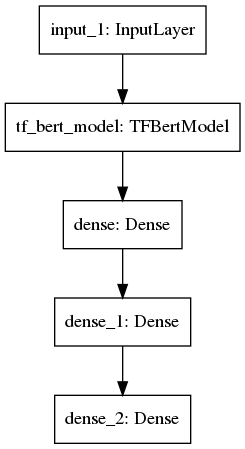

In [24]:
tf.keras.utils.plot_model(model)

In [25]:
def custom_loss(y_actual, y_pred):
    loss = tf.losses.sparse_categorical_crossentropy(y_actual, y_pred)
    loss = tf.reduce_mean(loss)
    return loss

In [26]:
model.compile(loss=custom_loss, optimizer='adam', metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [29]:
history = model.fit(
    x=train_dataset,
    batch_size=32, 
    epochs=3,
    validation_data=valid_dataset
)

Epoch 1/3
446/446 [==============================] - 24s 54ms/step - loss: 0.1932 - sparse_categorical_accuracy: 0.9721 - val_loss: 0.1384 - val_sparse_categorical_accuracy: 0.9775
Epoch 2/3
446/446 [==============================] - 23s 52ms/step - loss: 0.1608 - sparse_categorical_accuracy: 0.9739 - val_loss: 0.1381 - val_sparse_categorical_accuracy: 0.9775
Epoch 3/3
446/446 [==============================] - 23s 52ms/step - loss: 0.1589 - sparse_categorical_accuracy: 0.9739 - val_loss: 0.1411 - val_sparse_categorical_accuracy: 0.9775


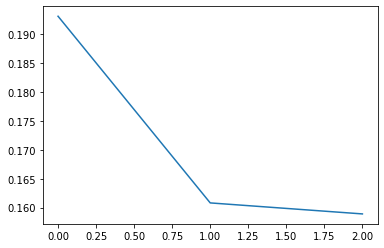

In [31]:
plt.plot(history.history['loss'])

In [43]:
inputs, labels = next(iter(valid_dataset))

In [44]:
labels

<tf.Tensor: shape=(512,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
     

In [46]:
predict = model.predict(inputs)

In [47]:
predict.argmax(axis=-1).squeeze()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## 結論 
V0 版本的模型，可能因為Class Imbalanced的關係，預測出來全部都是0